In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba

%matplotlib inline

## Functions

In [2]:
def init_conf_fcc(num_particles, rho_final, dtype=np.float32):
    """
    Function that generates an FCC (face-centered cubic) initial configuration for a 3D MD simulation, centered at the origin. 

    Parameters
    ----------
    num_particles : int 
        Desired number of particles in the configuration.
    rho_final : float
        Desired density of the configuration.
    dtype : data-type, callable, optional
        Data type for all simulation input. Defaults to np.float32 for speed.

    Returns
    -------
    final_conf : ndarray
        2D array containing the positions of N particles at the provided density. Particles are organized in an FCC lattice about the origin.
    final_sim_box : ndarray
        1D array containing the dimensions of the simulation box.

    Notes
    -----
    The function generates the minimum number of lattice cites necessary for a square simulation box, then populates those sites based on distance from the origin, with cites near the origin being filled first.

    """
    
    # define number of spatial dimensions
    D = 3
    
    # calculate the minimum number of cells along each dimension
    cell_per_dim = int(np.ceil((num_particles/4)**(1 / D)))

    # initiallize array of lattice sites
    sites = np.zeros((4*cell_per_dim**D, D), dtype=dtype)

    # loop over cells and generate lattice sites
    count = 0 
    for x in range(cell_per_dim):
        for y in range(cell_per_dim):
            for z in range(cell_per_dim):
                sites[count+0,:] = [x+0.25, y+0.25, z+0.25]
                sites[count+1,:] = [x+0.75, y+0.75, z+0.25]
                sites[count+2,:] = [x+0.75, y+0.25, z+0.75]
                sites[count+3,:] = [x+0.25, y+0.75, z+0.75]
                count += 4

    # center box on the origin
    for k in range(D):
        sites[:,k] -= np.mean(sites[:,k]) 

    # fill sites radially by distance from origin
    conf = sites[np.argsort(np.linalg.norm(sites, axis=1))]
    conf = conf[:num_particles]

    # get density scaling factor
    rho_initial = num_particles / cell_per_dim**D
    scale_factor = dtype((rho_initial/rho_final)**(1/D))

    # make sim box array
    sim_box = np.array([cell_per_dim]*3, dtype=dtype)

    # adjust density and return final arrays
    final_conf = conf*scale_factor
    final_sim_box = sim_box*scale_factor

    return final_conf, final_sim_box


### Test FCC configuration generator

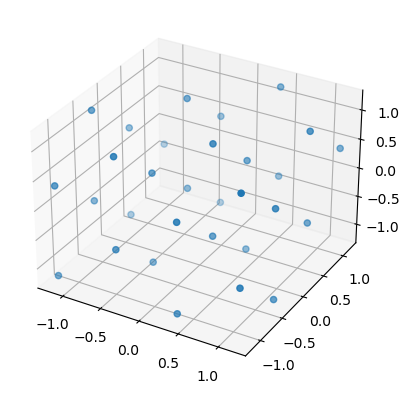

In [3]:
N = 30
rho = 1

xyz, _ = init_conf_fcc(N, rho)
fig = plt.figure()
ax = plt.axes(projection ="3d")

x, y, z = xyz.T
ax.scatter3D(x,y,z)
plt.show()

## More Functions

In [4]:
def generate_random_velocities(num_particles, T, m=1, D=3, dtype=np.float32):
    """
    Generate random velocities for particles in a molecular dynamics simulation.

    Parameters
    ----------
    num_particles : int
        Number of particles.
    T : float
        Desired temperature of the system.
    m : float, optional
        Mass of the particles (default is 1).
    D : int, optional
        Dimensionality of the system (default is 3).
    dtype : data-type, callable, optional
        The desired data type of the generated velocities (default is np.float32).

    Returns
    -------
    v : ndarray
        Array of random velocities with shape (N, D), where N is the number of particles
        and D is the dimensionality of the system.

    Notes
    -----
    The function generates random velocities for particles in a molecular dynamics simulation.
    The velocities are drawn from a normal distribution with mean 0 and standard deviation
    calculated based on the temperature T and mass m.
    Velocity drift is removed in each dimension to ensure the center of mass of the system
    remains stationary.

    """
    v = dtype(np.random.normal(0.0, (T/m) ** 0.5, (num_particles, D)))
    for k in range(D):
        v[:,k] -= np.mean(v[:,k]) # remove drift
    return v


def get_box_length(sim_box):
    """
    Get the side length of a cubic simulation box.

    Parameters
    ----------
    sim_box : ndarray
        1D array containing the dimensions of the simulation box.

    Returns
    -------
    L : float
        Side length of the cubic simulation box.

    Raises
    ------
    Exception
        If the simulation box is not square (i.e., if all dimensions are not equal).

    Notes
    -----
    This function returns the side length of a cubic simulation box. It checks if all dimensions of the box are equal and returns the side length if they are. If the dimensions are not equal, it raises an exception indicating that the box is not square.
    """
    if all(item == sim_box[0] for item in sim_box):
        L = sim_box[0]
        return L
    else:
        raise Exception('Box not square')


@numba.njit
def pot_LJ(r, eps, sig):
    """
    Calculate the Lennard-Jones potential energy between two particles.

    Parameters
    ----------
    r : float
        Distance between the particles.
    eps : float
        Strength of the interaction (epsilon parameter).
    sig : float
        Distance at which the potential energy is zero (sigma parameter).

    Returns
    -------
    pot : float
        Lennard-Jones potential energy between the particles.

    Notes
    -----
    The Lennard-Jones potential describes the pairwise interaction energy between particles in a system.
    It is used commonly in molecular dynamics simulations to model van der Waals forces.

    The potential energy (pot) is calculated using the formula:
    pot = 4 * eps * ((sigma/r)**12 - (sigma/r)**6)
    """
    pot = 4*eps*((sig / r) ** 12 - (sig / r) ** 6)
    return pot


@numba.njit
def calculate_distance(r_ij):
    """
    Calculate the distance between two particles given their relative positions.

    Parameters
    ----------
    r_ij : ndarray
        1D array containing the distance vector between the two particles.

    Returns
    -------
    r : float
        Distance between the two particles.

    Notes
    -----
    This function calculates the distance between two particles in a system given their relative positions.
    The distance (r) is computed as the Euclidean norm (L2 norm) of the relative positions vector.
    """
    r = sum(r_ij**2) ** 0.5
    return r


@numba.njit
def calculate_force(r, eps, sig):
    """
    Calculate the force between two particles using the Lennard-Jones potential.

    Parameters
    ----------
    r : float
        Distance between the particles.
    eps : float
        Strength of the interaction (epsilon parameter).
    sig : float
        Distance at which the potential energy is zero (sigma parameter).

    Returns
    -------
    force : float
        Force between the particles.

    Notes
    -----
    This function calculates the force between two particles using the Lennard-Jones potential.
    The force (force) is computed using the derivative of the Lennard-Jones potential with respect to distance.

    The force is given by the formula:
    force = 48 * eps * (sigma^12 / r^13 - 0.5 * (sigma^6 / r^7))
    """
    return 48*eps*(sig ** 12 / r ** 13 - 0.5 * (sig ** 6 / r ** 7))


@numba.njit
def calculate_U_and_F(conf, LJ_params, L, dtype=np.float32):
    """
    Calculate the potential energy and forces for a system of particles using the Lennard-Jones potential.

    Parameters
    ----------
    conf : ndarray
        2D array containing the positions of particles in the system.
    LJ_params : tuple
        Tuple containing the parameters (eps, sigma) of the Lennard-Jones potential.
    L : float
        Length of the simulation box.
    dtype : data-type, optional
        Data type for array elements (default is np.float32).

    Returns
    -------
    U : float
        Total potential energy of the system.
    F : ndarray
        2D array containing the forces acting on each particle.

    Notes
    -----
    This function calculates the potential energy and forces for a system of particles interacting via the Lennard-Jones potential.
    It uses the minimum image convention to enforce periodic boundary conditions.

    The potential energy (U) and forces (F) are calculated pairwise between all particles in the system.
    """
    U = 0
    N = len(conf)
    F = np.zeros_like(conf, dtype=dtype)
    for i in range(N-1):
        for j in range(i + 1, N):
            r_i = conf[i]
            r_j = conf[j]
            r_ij = r_j - r_i

            #enforce PBC with "minimum image convention"
            for idx, dim in enumerate(r_ij):
                if abs(dim) > 0.5*L:
                    if dim < 0:
                        r_ij[idx] = r_ij[idx] + L
                    else:
                        r_ij[idx] = r_ij[idx] - L
            
            # calculate energy
            r_norm = calculate_distance(r_ij)
            e = pot_LJ(r_norm, *LJ_params)
            U += e

            # calculate force
            F_ij = (r_ij / r_norm) * calculate_force(r_norm, *LJ_params)
            F[i] -= F_ij
            F[j] += F_ij
    
    return U, F


@numba.njit(parallel=True)
def enforce_PBC(conf, L):
    """
    Apply periodic boundary conditions (PBC) to particle positions within the simulation box.

    Parameters
    ----------
    conf : ndarray
        2D array containing the positions of particles in the simulation box.
    L : float
        Side length of the cubic simulation box.

    Returns
    -------
    conf : ndarray
        2D array containing the positions of particles with PBC applied.

    Notes
    -----
    This function applies periodic boundary conditions (PBC) to the particle positions within the simulation box.
    If a particle moves outside the box boundaries, it is wrapped back into the box using the minimum image convention.
    """
    # define box limits
    box_min = -0.5*L
    box_max = -box_min
    
    # loop over all particles and enforce PBC, utilizing numba parallelization
    for i in numba.prange(len(conf)):
        particle = conf[i]
        for j in numba.prange(len(particle)):
            dim = particle[j]
            if dim < box_min:
                conf[i,j] = conf[i,j] + L
            elif dim >= box_max:
                conf[i,j] = conf[i,j] - L
    return conf


@numba.njit
def run(conf_initial, L, dt, n_steps, v_i, tau, T=1, m=1, LJ_params=(1,1), dtype=np.float32):
    """
    Perform a molecular dynamics simulation using the velocity Verlet algorithm with the Nose-Hoover thermostat.

    Parameters
    ----------
    conf_initial : ndarray
        2D array containing the initial positions of particles.
    L : float
        Side length of the cubic simulation box.
    dt : float
        Time step of the simulation.
    n_steps : int
        Number of simulation steps to perform.
    v_i : ndarray
        2D array containing the initial velocities of particles.
    tau : float
        Relaxation time of the thermostat.
    T : float, optional
        Desired temperature of the system (default is 1).
    m : float, optional
        Mass of the particles (default is 1).
    LJ_params : tuple, optional
        Parameters (eps, sigma) for the Lennard-Jones potential (default is (1, 1)).
    dtype : data-type, callable, optional
        Data type for all simulation input (default is np.float32).

    Returns
    -------
    U_total : ndarray
        1D array containing the total potential energy at each step of the simulation.
    K_total : ndarray
        1D array containing the total kinetic energy at each step of the simulation.
    conf_all : ndarray
        3D array containing the positions of particles at each step of the simulation.

    Notes
    -----
    This function performs a molecular dynamics simulation using the velocity Verlet algorithm with the Nose-Hoover thermostat.
    It integrates the equations of motion for particles in a cubic simulation box, applying periodic boundary conditions.
    The simulation includes energy calculations and thermostat updates to maintain the desired temperature.
    """
    # initiallize configuration storage array
    conf_all = np.zeros((n_steps+1, *conf_initial.shape), dtype=dtype)

    # initiallize energy storage arrays
    U_total = np.zeros(n_steps+1, dtype=dtype)
    K_total = np.zeros(n_steps+1, dtype=dtype)

    # set initial conditions
    conf_all[0] = conf_initial
    v = v_i
    eta = dtype(0)
    N = dtype(conf_initial.shape[0])
    D = dtype(conf_initial.shape[1])
    U_total[0], F = calculate_U_and_F(conf_all[0], LJ_params, L)
    K_total[0] = np.sum(0.5*m*v**2)

    for step in range(n_steps):
        # perform kick-drift-kick leapfrog algorithm with Nose hoover thermostat, from toxvaerd
        a = F/m
        v_half = v + a*dt/2 - eta*v
        conf_all[step+1] = conf_all[step] + v_half*dt
        conf_all[step+1] = enforce_PBC(conf_all[step+1], L)
        U_total[step+1], F = calculate_U_and_F(conf_all[step+1], LJ_params, L)

        a_1 = F/m
        eta_1 = eta + dt/tau * (np.sum(m*v_half**2 / D)/N - T)
        v_1 = v_half + a_1*dt/2 - eta_1*v_half
        
        # Update variables for next step
        a = a_1
        v = v_1
        eta = eta_1

        K_total[step+1] = np.sum(0.5*m*v**2)

    return U_total, K_total, conf_all


## Run Simulation

In [5]:
# set sim box parameters
N = 10
rho = 0.2

# generate sim box
initial_configuration, box = init_conf_fcc(N, rho)
box_length = get_box_length(box)

# set simulation and thermostat parameters
time_step = 0.001
num_steps = 10000
Temp = 5
thermostat_relaxation = 100

# set particle parameters
mass = 1
epsilon = 3
sigma = 1
lennard_jones_params = (epsilon, sigma)

# generate initial random velocities
initial_velocities = generate_random_velocities(N, Temp, mass)

# run simulation
U, K, confs = run(initial_configuration, box_length, np.float32(time_step), num_steps, initial_velocities, np.float32(thermostat_relaxation), np.float32(Temp), mass, lennard_jones_params)

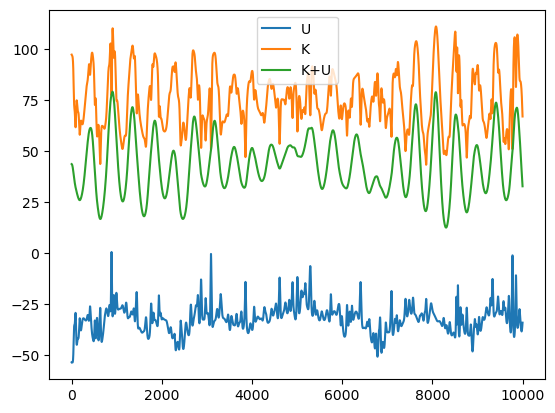

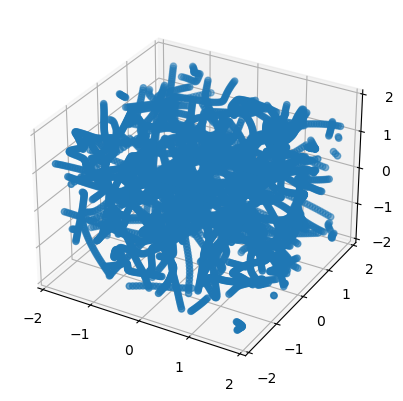

In [6]:
plt.figure()
plt.plot(U, label="U")
plt.plot(K, label="K")
plt.plot(K+U, label="K+U")
plt.legend()
plt.show()

plt.figure()
ax = plt.axes(projection ="3d")
x, y, z = confs[0::10].T
ax.scatter(x,y,z)
plt.show()